**1. Most Likely Digits (20 Points)**

To solve the problem for the optimal digit images, we first will use the no hidden layer MNIST model and the best model we used from hw2. In this case, it will be the model with decreasing layers. Then we will use this model and train it on the MNIST dataset. After training our model, we will then freeze the parameters of our model. We will initialize random inputs for every digit (0-9) and then use gradient descent to find the optimal input. Then we will get our optimal input and print the image.

**OPTIMAL NETWORK**

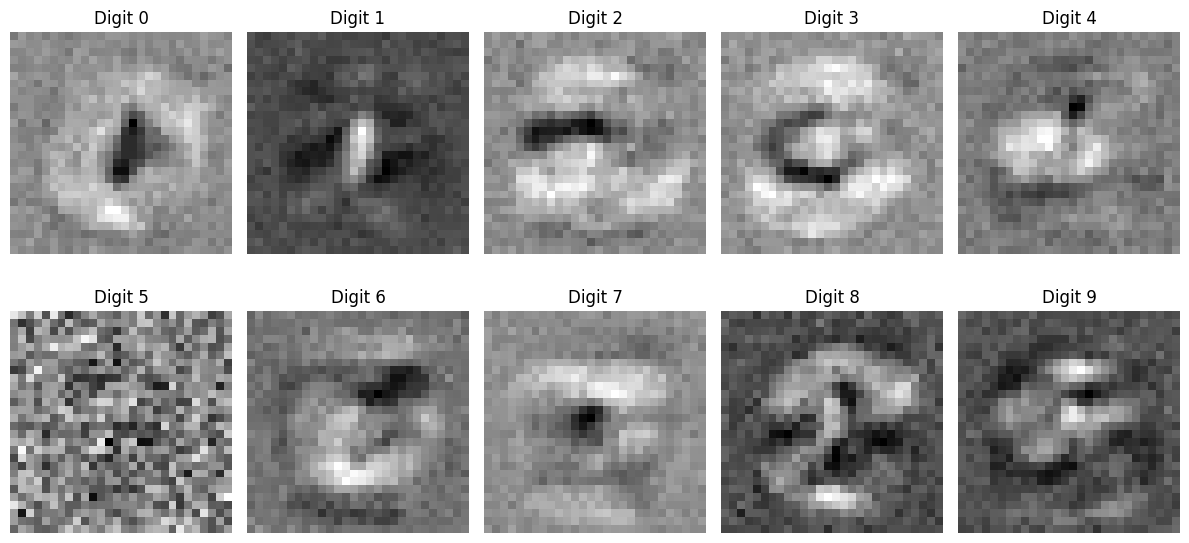

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import random

class DecreasingLayersMNISTSoftMaxModel(nn.Module):
    def __init__(self):
        super(DecreasingLayersMNISTSoftMaxModel, self).__init__()

        self.layer_1 = torch.nn.Linear( in_features = 28*28, out_features = 256, bias=True )
        self.layer_2 = torch.nn.Linear( in_features = 256, out_features = 64, bias=True )
        self.output_layer = torch.nn.Linear( in_features = 64, out_features = 10, bias=True )
        
    def forward(self, input_tensor):
        flattened = nn.Flatten()( input_tensor )

        output = self.layer_1( flattened )
        output = torch.nn.ReLU()( output )

        output = self.layer_2( output )      
        output = torch.nn.ReLU()( output )

        output = self.output_layer(output)
        logits = torch.nn.Softmax( dim = 1 )( output )
        return logits
    
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_x = mnist_trainset.data / 256.0  # Scale values between 0 and 1
train_y = mnist_trainset.targets
test_x = mnist_testset.data / 256.0
test_y = mnist_testset.targets
TRAIN_N = train_x.shape[0]
TEST_N = test_x.shape[0]

BATCH_SIZE = 256

def get_batch(x, y, batch_size):
    n = x.shape[0]
    
    batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

    x_batch = x[ batch_indices ]
    y_batch = y[ batch_indices ]
    
    return x_batch, y_batch

def confusion_matrix( model, x, y ):
    identification_counts = np.zeros( shape = (10,10), dtype = np.int32 )
    
    logits = model( x )
    predicted_classes = torch.argmax( logits, dim = 1 )
    
    n = x.shape[0]
    
    for i in range(n):
        actual_class = y[i]
        predicted_class = predicted_classes[i].item()
        identification_counts[actual_class, predicted_class] += 1
    
    return identification_counts

model_dec = DecreasingLayersMNISTSoftMaxModel()
optimizer_dec = optim.SGD(model_dec.parameters(), lr=0.1)
loss_function_dec = torch.nn.CrossEntropyLoss()

# training loop
num_epochs = 20
for epoch in range(num_epochs):
    model_dec.train()  
    training_loss = 0
    testing_loss = 0
    for batch in range(0, TRAIN_N, BATCH_SIZE):
        x_batch, y_batch = get_batch(train_x, train_y, BATCH_SIZE)        
        optimizer_dec.zero_grad()
        outputs = model_dec(x_batch)
        loss = loss_function_dec(outputs, y_batch)
        loss.backward()
        optimizer_dec.step()
        training_loss += loss.item()

    with torch.no_grad():
        model_dec.eval()
        for batch in range( TEST_N // BATCH_SIZE ):
            x_batch, y_batch = get_batch(test_x, test_y, BATCH_SIZE)
            logits = model_dec(x_batch)
            test_loss = loss_function_dec(logits, y_batch)
            testing_loss += test_loss.item()

        model_dec.train()
    
    # Print average loss for the epoch
    # print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss / (TRAIN_N / BATCH_SIZE)}")
    # print(f"Epoch [{epoch+1}/{num_epochs}], Testing Loss: {testing_loss / (TEST_N / BATCH_SIZE)}")

model_dec.eval()
num_iterations = 3000
optimized_images = []

for digit in range(10):
    input_tensor = (0.01 * torch.randn(1, 1, 28, 28)).requires_grad_()     
    
    for param in model_dec.parameters():
        param.requires_grad = False
    
    optimizer = optim.SGD([input_tensor], lr=1)

    target_output = torch.zeros(1, 10)
    target_output[0, digit] = 1

    for _ in range(num_iterations):
        output = model_dec(input_tensor)
        loss = loss_function_dec(output, target_output)

        loss.backward()
        optimizer.step()

        # print(f"Digit: {digit}, Iteration: {_+1}, Loss: {loss.item()}")

    optimized_images.append(input_tensor.squeeze().detach().numpy())

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(optimized_images[i], cmap='gray')
    ax.set_title(f'Digit {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

**NO HIDDEN LAYER NETWORK**

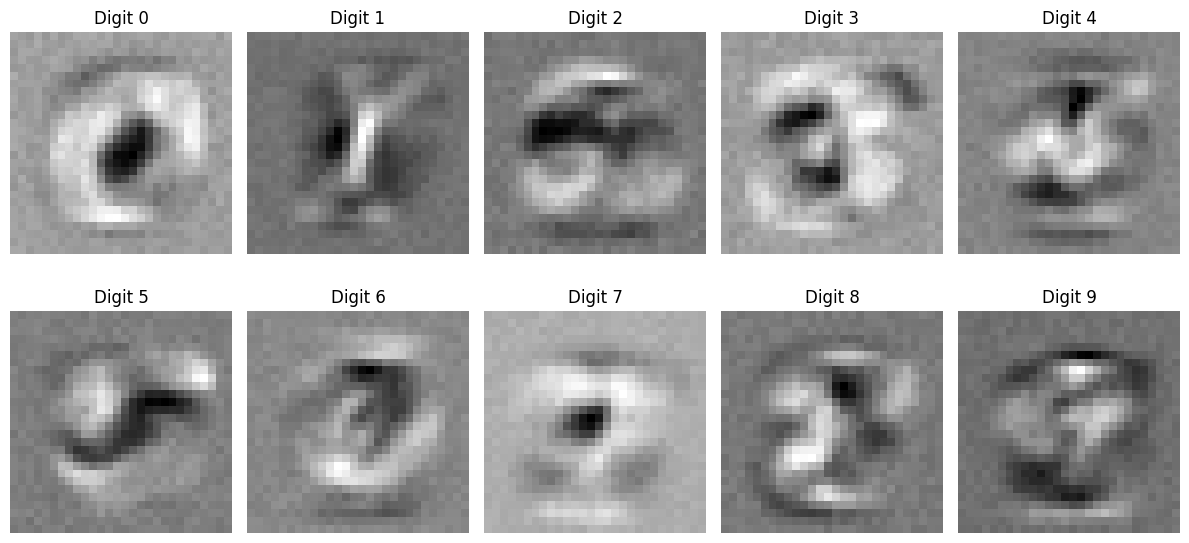

In [ ]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # To use the GPU

class LinearMNISTSoftMaxModel(nn.Module):
    def __init__(self):
        super(LinearMNISTSoftMaxModel, self).__init__()
        self.linear_layer = torch.nn.Linear( in_features = 28*28, out_features = 10, bias=True )
        
    def forward(self, input_tensor):
        flattened = nn.Flatten()( input_tensor )
        output = self.linear_layer( flattened )
        probabilities = torch.nn.Softmax( dim = 1 )( output )
        
        return probabilities
    
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_x = mnist_trainset.data / 256.0  # Scale values between 0 and 1
train_y = mnist_trainset.targets
test_x = mnist_testset.data / 256.0
test_y = mnist_testset.targets
TRAIN_N = train_x.shape[0]
TEST_N = test_x.shape[0]

BATCH_SIZE = 256

def get_batch(x, y, batch_size):
    n = x.shape[0]
    
    batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

    x_batch = x[ batch_indices ]
    y_batch = y[ batch_indices ]
    
    return x_batch, y_batch

def confusion_matrix( model, x, y ):
    identification_counts = np.zeros( shape = (10,10), dtype = np.int32 )
    
    logits = model( x )
    predicted_classes = torch.argmax( logits, dim = 1 )
    
    n = x.shape[0]
    
    for i in range(n):
        actual_class = y[i]
        predicted_class = predicted_classes[i].item()
        identification_counts[actual_class, predicted_class] += 1
    
    return identification_counts

linear_model = LinearMNISTSoftMaxModel()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.1)
loss_function = torch.nn.CrossEntropyLoss()

# training loop
num_epochs = 30
for epoch in range(num_epochs):
    linear_model.train()  
    training_loss = 0
    testing_loss = 0
    for batch in range(0, TRAIN_N, BATCH_SIZE):
        x_batch, y_batch = get_batch(train_x, train_y, BATCH_SIZE)        
        optimizer.zero_grad()
        outputs = linear_model(x_batch)
        loss = loss_function(outputs, y_batch)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    with torch.no_grad():
        linear_model.eval()
        for batch in range( TEST_N // BATCH_SIZE ):
            x_batch, y_batch = get_batch(test_x, test_y, BATCH_SIZE)
            logits = linear_model(x_batch)
            test_loss = loss_function(logits, y_batch)
            testing_loss += test_loss.item()

        linear_model.train()
    
    # Print average loss for the epoch
    # print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss / (TRAIN_N / BATCH_SIZE)}")
    # print(f"Epoch [{epoch+1}/{num_epochs}], Testing Loss: {testing_loss / (TEST_N / BATCH_SIZE)}")

linear_model.eval()
num_iterations = 2500
optimized_images = []

for digit in range(10):
    input_tensor = torch.randn(1, 1, 28, 28, requires_grad=True)

    for param in linear_model.parameters():
        param.requires_grad = False
    
    optimizer = optim.SGD([input_tensor], lr=1)

    target_output = torch.zeros(1, 10)
    target_output[0, digit] = 1

    for _ in range(num_iterations):
        output = linear_model(input_tensor)
        loss = loss_function(output, target_output)
        
        loss.backward()
        optimizer.step()

        # print(f"Digit: {digit}, Iteration: {_+1}, Loss: {loss.item()}")

    optimized_images.append(input_tensor.squeeze().detach().numpy())

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(optimized_images[i], cmap='gray')
    ax.set_title(f'Digit {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

The images suggest that the two networks look for common key features that are characteristic of each digit. For example, we can see for both networks, it was able to recognize the circular shape that a "0" has. The similarities that we can see is that the numbers that consisted of mostly curves like 0 and 3 were very recognizable. However, some differences is that we can see that the no layer network had a higher success of printing out the optimal images rather than the "optimal" network.

**Bonus**: We should stop training when the loss starts to plateau. In my loss results, I could see that with higher iterations, the loss slowly stopped getting significantly better. Overfitting/over training here means that the model listens to too much noises and fails to capture the key feature of the digit.

**2. Change Point Detection (20 Points)**

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define generate_batch function
def generate_batch(K, L):
    batch_sequences = []
    batch_labels = []
    
    for _ in range(K):
        sequence = np.random.randn(100, 10)
        
        change_point = np.random.choice([True, False])
        
        if change_point:
            change_idx = np.random.randint(1, 100)  
            label = 1
            means = np.random.uniform(-1, 1, size=5)
            indices = np.random.choice(10, size=5, replace=False)
            for t in range(change_idx, 100):
                sequence[t, indices] += means
        else:
            label = 0
        
        sequence = sequence[:L]
        
        batch_sequences.append(sequence)
        batch_labels.append(label)
    
    return np.array(batch_sequences), np.array(batch_labels) 


Epoch 1, Loss: 22.181672
Epoch 2, Loss: 22.029823
Epoch 3, Loss: 21.674875
Epoch 4, Loss: 21.649200
Epoch 5, Loss: 21.276505
Epoch 6, Loss: 20.174206
Epoch 7, Loss: 18.702415
Epoch 8, Loss: 17.343353
Epoch 9, Loss: 16.397885
Epoch 10, Loss: 15.357408
Epoch 11, Loss: 14.965009
Epoch 12, Loss: 14.415315
Epoch 13, Loss: 13.160825
Epoch 14, Loss: 11.990569
Epoch 15, Loss: 11.400004
Epoch 16, Loss: 11.480486
Epoch 17, Loss: 12.625204
Epoch 18, Loss: 10.382561
Epoch 19, Loss: 9.489226
Epoch 20, Loss: 9.131148
Epoch 21, Loss: 9.997453
Epoch 22, Loss: 8.464068
Epoch 23, Loss: 9.701606
Epoch 24, Loss: 8.507286
Epoch 25, Loss: 8.371746
Epoch 26, Loss: 7.070318
Epoch 27, Loss: 7.572793
Epoch 28, Loss: 6.524253
Epoch 29, Loss: 5.866970
Epoch 30, Loss: 6.220930


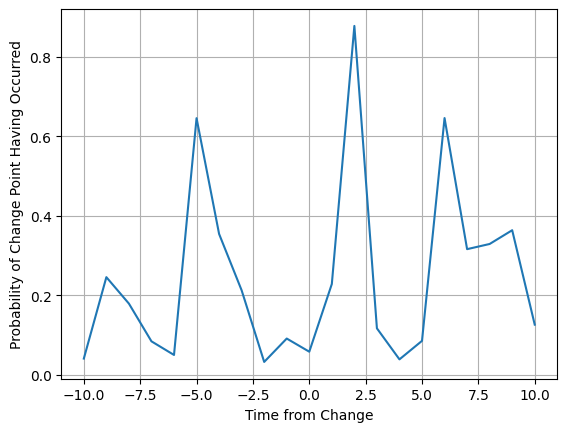

In [37]:
class ChangePointDetectionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ChangePointDetectionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        output = self.fc(h_n.squeeze(0))
        output = self.sigmoid(output)
        return output

def train_model(model, train_loader, epochs):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print('Epoch %d, Loss: %f' % (epoch+1, running_loss))

# Generate training data
X_train, y_train = generate_batch(1000, 50)  

# Train the model
model = ChangePointDetectionModel(input_size=10, hidden_size=64)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float()), batch_size=32)
train_model(model, train_loader, epochs=30)

def calculate_detection_probabilities(model, sequence_length):
    probabilities = []
    with torch.no_grad():
        for t in range(-10, 11):
            sequence = np.random.randn(sequence_length, 10)
            if t < 0:
                sequence[:t, :] = np.random.randn(sequence_length + t, 10)
            elif t > 0:
                sequence[t:, :] = np.random.randn(sequence_length - t, 10)
            sequence = torch.Tensor(sequence).unsqueeze(0)  
            pred = model(sequence)
            probabilities.append(pred.item())
    return probabilities


# Calculate detection probabilities
probabilities = calculate_detection_probabilities(model, 50)  
# Plot detection probabilities
time_from_change = list(range(-10, 11))
plt.plot(time_from_change, probabilities)
plt.xlabel('Time from Change')
plt.ylabel('Probability of Change Point Having Occurred')
plt.grid(True)
plt.show()


Epoch 1, Loss: 22.674442
Epoch 2, Loss: 22.172992
Epoch 3, Loss: 22.142752
Epoch 4, Loss: 22.059616
Epoch 5, Loss: 21.912634
Epoch 6, Loss: 21.709916
Epoch 7, Loss: 21.420525
Epoch 8, Loss: 21.022689
Epoch 9, Loss: 20.576202
Epoch 10, Loss: 20.015601
Epoch 11, Loss: 19.374073
Epoch 12, Loss: 18.730912
Epoch 13, Loss: 18.020658
Epoch 14, Loss: 17.301284
Epoch 15, Loss: 16.591754
Epoch 16, Loss: 15.881924
Epoch 17, Loss: 15.237680
Epoch 18, Loss: 14.629270
Epoch 19, Loss: 14.315304
Epoch 20, Loss: 14.145357
Epoch 21, Loss: 14.021579
Epoch 22, Loss: 13.251225
Epoch 23, Loss: 12.450523
Epoch 24, Loss: 11.827145
Epoch 25, Loss: 11.282405
Epoch 26, Loss: 10.843897
Epoch 27, Loss: 10.541613
Epoch 28, Loss: 10.610234
Epoch 29, Loss: 10.150020
Epoch 30, Loss: 9.829268


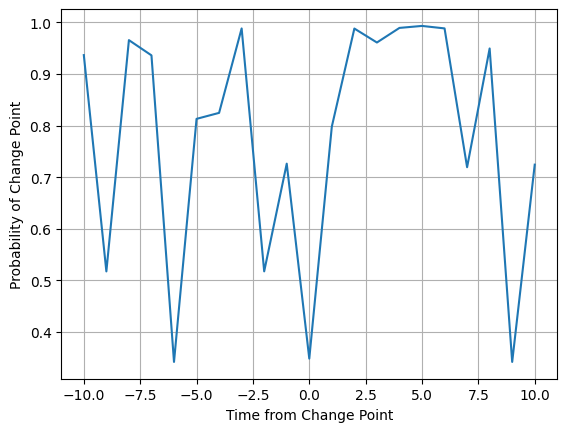

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 1D-CNN model
class ChangePointDetectionCNN(nn.Module):
    def __init__(self):
        super(ChangePointDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 24, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x.permute(0, 2, 1))
        x = self.relu(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Generate training data
X_train, y_train = generate_batch(1000, 50)

# Train the CNN model
model = ChangePointDetectionCNN()
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float()), batch_size=32)
train_model(model, train_loader, epochs=30)

# Calculate detection probabilities
probabilities = calculate_detection_probabilities(model, 50) 

# Plot detection probabilities
time_from_change = list(range(-10, 11))
plt.plot(time_from_change, probabilities)
plt.xlabel('Time from Change Point')
plt.ylabel('Probability of Change Point')
plt.grid(True)
plt.show()

From the graphs, we can clearly see that 1D-CNN is better in detecting change points as there are more points where the probability is close to 1. The reason why this network worked better could be because the 1D-CNN was able to capture the features in the data better. We can also see that the 1D-CNN worked just as well for change points outside the time horizon it was trained on.

**3. Summarization**

In [ ]:
def summarize(seq):
    summary = [0] * 10
    for value in seq:
        summary[value] += 1
    return summary

def query(summary, q):
    return summary[q] > 0

In the code above, I define summary as simply a list that gives us the details of many occurrences there are of integers that happen in the given sequence. For query, it will return us the boolean value of whether the summary contains a postive result of the query value or not.

In [7]:
import torch
import torch.nn as nn

def generate_data(num_sequences, sequence_len, num_tokens):
    data = []
    queries = []
    comparisons = []

    middle_index = num_sequences // 2

    # Generate sequences with positive queries
    for _ in range(middle_index):
        tokens = torch.randperm(10)[:num_tokens]
        seq = tokens[torch.randint(0, num_tokens, (sequence_len,))]  
        data.append(seq)

        query_token_index = torch.randint(0, sequence_len, (1,))
        query_token = seq[query_token_index].item()  
        queries.append(query_token)

        comparisons.append(int(query_token in seq))  

    # Generate sequences with negative queries
    for _ in range(middle_index):
        tokens = torch.randperm(10)[:num_tokens]
        seq = tokens[torch.randint(0, num_tokens, (sequence_len,))]
        data.append(seq)

        query_token = torch.randint(0, 10, (1,)).item()  
        while query_token in seq:
            query_token = torch.randint(0, 10, (1,)).item()  
        queries.append(query_token)

        comparisons.append(int(query_token in seq))  

    data_vectors = torch.stack(data)
    query_vectors = torch.tensor(queries)  
    comparisons = torch.tensor(comparisons)

    # Shuffle the sequences and queries
    indices = torch.randperm(len(data))
    data_vectors = data_vectors[indices]
    query_vectors = query_vectors[indices]
    comparisons = comparisons[indices]

    return data_vectors, query_vectors, comparisons


class SequenceSummaryModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(SequenceSummaryModel, self).__init__()
        self.embedding = nn.Embedding(10, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        summary = output[:, -1, :] 
        return summary

class QueryModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(QueryModel, self).__init__()
        self.fc1 = nn.Linear(embedding_dim + hidden_dim, hidden_dim)  
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, summary, query):
        concatenated = torch.cat((summary, query), dim=1)
        out = self.fc1(concatenated)
        out = torch.relu(out)
        out = self.fc2(out)
        prob = self.sigmoid(out)
        return prob

def generate_sequence(length):
    return torch.tensor(np.random.randint(0, 10, size=(length,)), dtype=torch.long)

def generate_query():
    return torch.tensor(np.random.randint(0, 10), dtype=torch.long)

# Generate data
num_sequences = 10
seq_length = 10
num_tokens = 7 

sequences, queries, comparisons = generate_data(num_sequences, seq_length, num_tokens)

# parameters
embedding_dim = 2
hidden_dim = 6
lr = 0.001
num_epochs = 10

# Initialize models
summary_model = SequenceSummaryModel(embedding_dim, hidden_dim)
query_model = QueryModel(embedding_dim, hidden_dim)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer_summary = torch.optim.Adam(summary_model.parameters(), lr=lr)
optimizer_query = torch.optim.Adam(query_model.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    total_loss_query = 0
    
    for seq, q in zip(sequences, queries):
        optimizer_summary.zero_grad()
        optimizer_query.zero_grad()
        
        # Forward pass for summary model
        summary = summary_model(seq.unsqueeze(0))  
        
        # Forward pass for query model
        query_embedded = summary_model.embedding(q.unsqueeze(0))
        prob = query_model(summary, query_embedded)
        
        # Compute loss and backpropagation
        target = torch.tensor([[1.0]]) if q.item() in seq else torch.tensor([[0.0]]) 
        loss_query = criterion(prob, target)
        
        loss = loss_query
        loss.backward()
        
        # Update weights
        optimizer_summary.step()
        optimizer_query.step()
        
        total_loss_query += loss_query.item()
    
    # Print average loss for this epoch
    print(f"Epoch {epoch+1}, Query Loss: {total_loss_query/num_sequences}")

# Evaluation
def query_sequence(summary_model, query_model, seq, q):
    summary = summary_model(seq.unsqueeze(0))
    query_embedded = summary_model.embedding(q.unsqueeze(0))
    prob = query_model(summary, query_embedded)
    return prob.item()

# Test with a random sequence and query
test_seq = generate_sequence(seq_length)
test_query = generate_query()
print("Test Sequence:", test_seq)
print("Test Query:", test_query)
print("Probability of Query in Sequence:", query_sequence(summary_model, query_model, test_seq, test_query))

Epoch 1, Query Loss: 0.7159167647361755
Epoch 2, Query Loss: 0.7115867793560028
Epoch 3, Query Loss: 0.7084747076034545
Epoch 4, Query Loss: 0.7055093288421631
Epoch 5, Query Loss: 0.7026307106018066
Epoch 6, Query Loss: 0.6998203694820404
Epoch 7, Query Loss: 0.6970670342445373
Epoch 8, Query Loss: 0.6943874716758728
Epoch 9, Query Loss: 0.6917714476585388
Epoch 10, Query Loss: 0.6891875565052032
Test Sequence: tensor([2, 3, 5, 0, 9, 5, 5, 7, 3, 3])
Test Query: tensor(7)
Probability of Query in Sequence: 0.5438088178634644


**4. Delving Deeper**

In [17]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import deque
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_X = torch.Tensor( trainset.data/255.0 - 0.5 )
train_X = train_X.permute( 0, 3, 1, 2 )
test_X = torch.Tensor( testset.data/255.0 - 0.5 )
test_X = test_X.permute( 0, 3, 1, 2 )

train_Y = torch.Tensor( np.asarray( trainset.targets ) ).long()
test_Y = torch.Tensor( np.asarray( testset.targets ) ).long()

def get_batch(x, y, batch_size):
  n = x.shape[0]

  batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

  x_batch = x[ batch_indices ]
  y_batch = y[ batch_indices ]

  return x_batch, y_batch

batch_x, batch_y = get_batch( train_X, train_Y, batch_size = 4 )

def confusion_matrix( model, x, y ):
  identification_counts = np.zeros( shape = (10,10), dtype = np.int32 )

  logits = model( x )
  predicted_classes = torch.argmax( logits, dim = 1 )

  n = x.shape[0]

  for i in range(n):
    actual_class = int( y[i].item() )
    predicted_class = predicted_classes[i].item()
    identification_counts[actual_class, predicted_class] += 1

  return identification_counts


Files already downloaded and verified
Files already downloaded and verified


In [21]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # To use the GPU

resnet = models.resnet50(pretrained=True)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet.layer4.add_module("Dropout", nn.Dropout(0.5))
resnet.layer4.add_module("BatchNorm", nn.BatchNorm2d(2048))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))


c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,   100] loss: 1.872
[1,   200] loss: 1.226
[1,   300] loss: 1.050
[1,   400] loss: 0.909
[1,   500] loss: 0.843
[1,   600] loss: 0.787
[1,   700] loss: 0.766
[2,   100] loss: 0.553
[2,   200] loss: 0.560
[2,   300] loss: 0.575
[2,   400] loss: 0.569
[2,   500] loss: 0.540
[2,   600] loss: 0.536
[2,   700] loss: 0.552
[3,   100] loss: 0.371
[3,   200] loss: 0.373
[3,   300] loss: 0.375
[3,   400] loss: 0.375
[3,   500] loss: 0.371
[3,   600] loss: 0.388
[3,   700] loss: 0.396
[4,   100] loss: 0.251
[4,   200] loss: 0.240
[4,   300] loss: 0.264
[4,   400] loss: 0.264
[4,   500] loss: 0.264
[4,   600] loss: 0.278
[4,   700] loss: 0.295
[5,   100] loss: 0.186
[5,   200] loss: 0.165
[5,   300] loss: 0.173
[5,   400] loss: 0.180
[5,   500] loss: 0.203
[5,   600] loss: 0.205
[5,   700] loss: 0.215
Finished Training
Accuracy of the network on the 10000 test images: 81 %


I implemented transfer learning here by using a pre-trained ResNet-50 model. I added dropout and batch normalization. Through these processes, I was able to have a good loss decrease as well as a high accuracy.

**5. Contrastive Learning**

In [4]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import deque
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_X = torch.Tensor( trainset.data/255.0 - 0.5 )
train_X = train_X.permute( 0, 3, 1, 2 )
test_X = torch.Tensor( testset.data/255.0 - 0.5 )
test_X = test_X.permute( 0, 3, 1, 2 )

train_Y = torch.Tensor( np.asarray( trainset.targets ) ).long()
test_Y = torch.Tensor( np.asarray( testset.targets ) ).long()

def get_batch(x, y, batch_size):
  n = x.shape[0]

  batch_indices = random.sample( [ i for i in range(n) ], k = batch_size )

  x_batch = x[ batch_indices ]
  y_batch = y[ batch_indices ]

  return x_batch, y_batch

batch_x, batch_y = get_batch( train_X, train_Y, batch_size = 4 )

def confusion_matrix( model, x, y ):
  identification_counts = np.zeros( shape = (10,10), dtype = np.int32 )

  logits = model( x )
  predicted_classes = torch.argmax( logits, dim = 1 )

  n = x.shape[0]

  for i in range(n):
    actual_class = int( y[i].item() )
    predicted_class = predicted_classes[i].item()
    identification_counts[actual_class, predicted_class] += 1

  return identification_counts

Files already downloaded and verified
Files already downloaded and verified


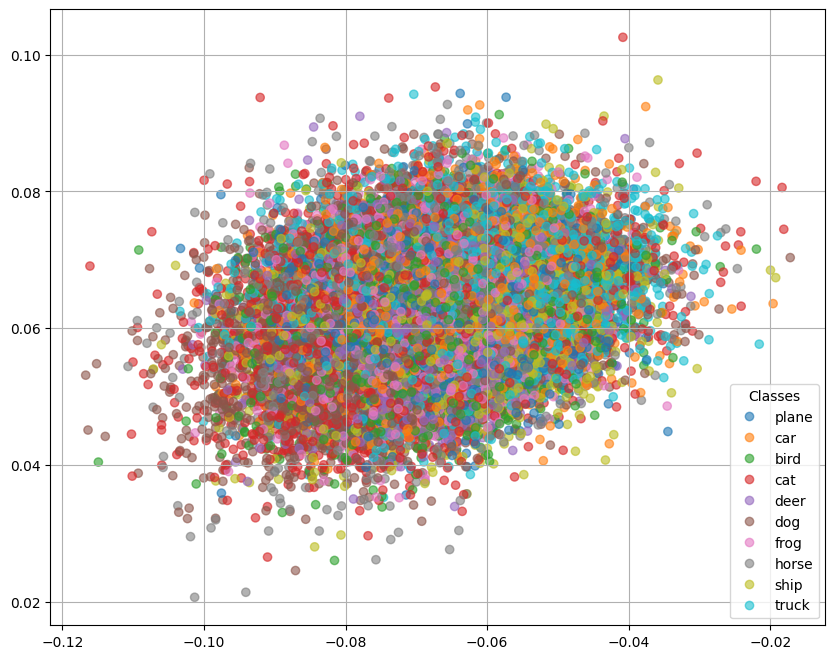

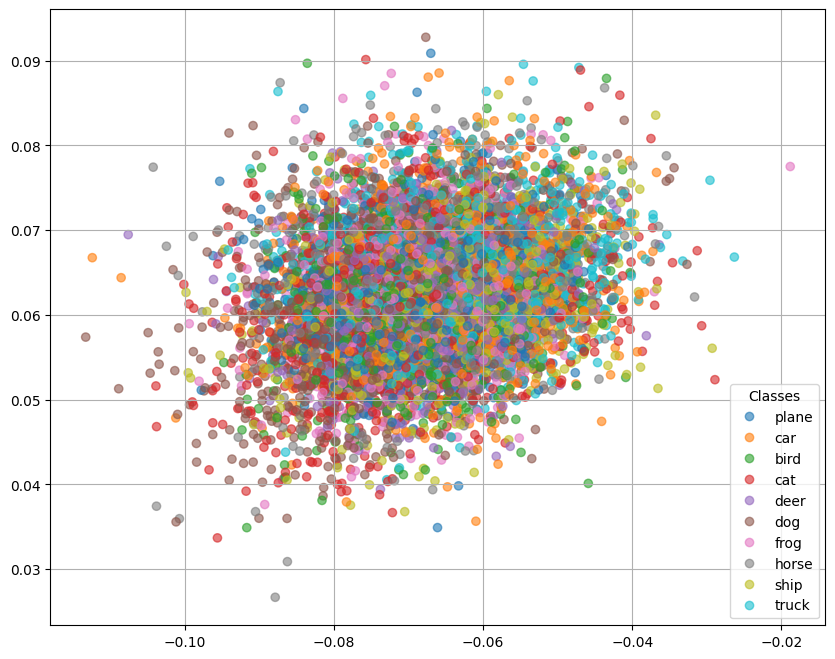

In [5]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # To use the GPU

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 2)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ContrastiveLoss(nn.Module):
    def __init__(self, M=100.0): 
        super(ContrastiveLoss, self).__init__()
        self.M = M

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                       (label) * torch.pow(torch.clamp(self.M - euclidean_distance, min=0.0), 2))
        return loss_contrastive
  
def extract_embeddings(dataloader, model):
    model.eval()  
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in dataloader:
            inputs, targets = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            embeddings.append(outputs)
            labels.append(targets)

    embeddings = torch.cat(embeddings).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    return embeddings, labels

# Function to plot embeddings
def plot_embeddings(embeddings, labels, classes):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.6)
    handles, _ = scatter.legend_elements()
    legend = plt.legend(handles, classes, loc='best', title="Classes")
    plt.grid(True)
    plt.show()

# Initialize the embedding network and loss function
embedding_net = EmbeddingNet().to(device)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(embedding_net.parameters(), lr=0.001)

initial_train_embeddings, initial_train_labels = extract_embeddings(trainloader, embedding_net)
initial_test_embeddings, initial_test_labels = extract_embeddings(testloader, embedding_net)

# Plot training and testing embeddings
plot_embeddings(initial_train_embeddings, initial_train_labels, classes)
plot_embeddings(initial_test_embeddings, initial_test_labels, classes)



Epoch 1, Loss: 928.3095629367682
Epoch 2, Loss: 916.8508582200541
Epoch 3, Loss: 918.5576093239553
Epoch 4, Loss: 924.8079631102969
Epoch 5, Loss: 921.7925760117943
Epoch 6, Loss: 914.0283391713486
Epoch 7, Loss: 936.1342966026052
Epoch 8, Loss: 928.5040669746106
Epoch 9, Loss: 933.8741826254999
Epoch 10, Loss: 917.6601885139485


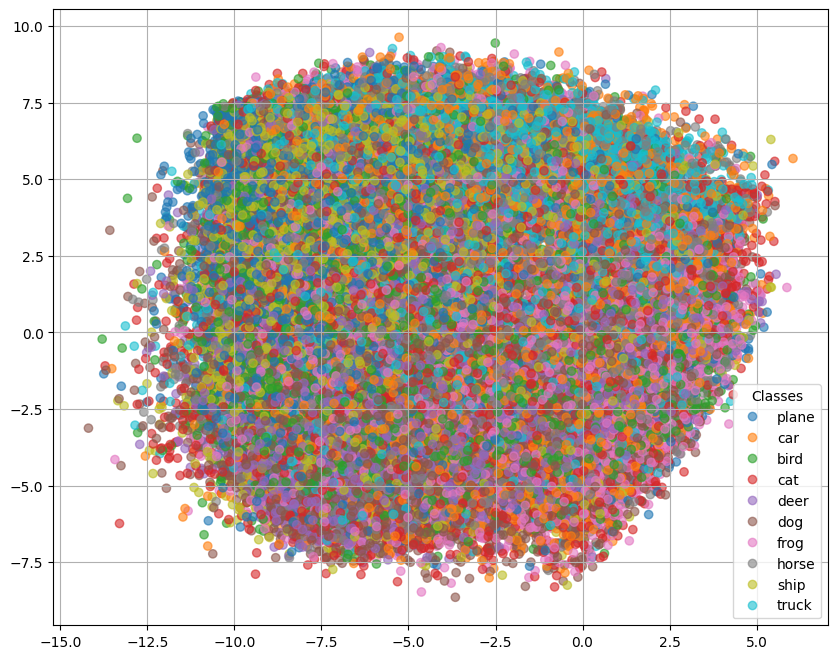

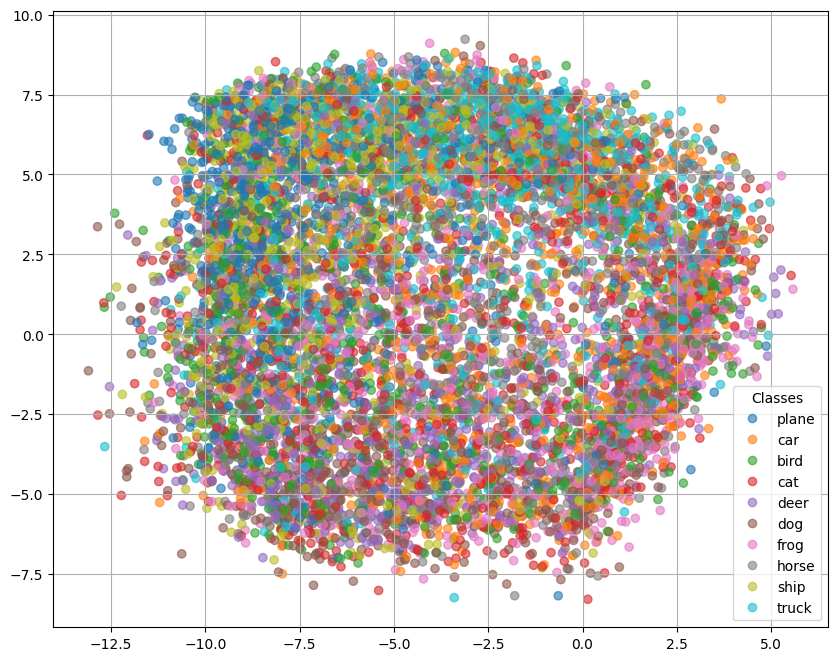

In [6]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # Generate pairs of inputs and labels for contrastive loss
        anchor, positive = inputs[::2], inputs[1::2]
        anchor_labels, positive_labels = labels[::2], labels[1::2]
        labels_contrastive = torch.eq(anchor_labels, positive_labels).float().to(device)

        # Forward pass
        outputs_anchor = embedding_net(anchor)
        outputs_positive = embedding_net(positive)

        loss = criterion(outputs_anchor, outputs_positive, labels_contrastive)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}")

train_embeddings, train_labels = extract_embeddings(trainloader, embedding_net)
test_embeddings, test_labels = extract_embeddings(testloader, embedding_net)

# Plot training and testing embeddings
plot_embeddings(train_embeddings, train_labels, classes)
plot_embeddings(test_embeddings, test_labels, classes)


For the most part, we can see that the contrastive loss is decreasing. We can see that overfitting happens when the loss doesn't decrease anymore and instead starts increasing instead. Using different values of m from 0 to 100, I can see that at higher m values, the results are better as the trained embedding network puts similar things much closer together and the groupings are very clear.